# Assignment 8

In [ ]:
# Your task here is to modify the code we developed in class to calculate ozone formation as a function of NOx and RH (hydrocarbon) mixing ratio 
# to create an "ozone isopleth plot" as in the accompanying slide show on this lecture topic. See the figure in the last slide. You will want to 
# write a function that takes as input NOx and RH mixing ratios (in ppb) and outputs maximum O3. Then make a contour plot of maximum O3 concentration 
# as a function of input NOx and RH mixing ratio. Express the O3 concentration in ppb as well. You can use a range of 0-50 ppb for initial NOx and 
# 50-500 ppb for initial RH (hydrocarbon). Upload your u[1]tebook to github and provide the link as usual. Compare to the plot in the slideshow 
# (final slide) to confirm your solution. 

In [98]:
# Import Packages
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import os

In [99]:
# Input (Given) Data / Define Constants
temp = 298     # Kelvin
pres = 1000    # milibars or Hectopascals (10^5 pascals)
Rgas = 8.314   # J/mol-1K-1 (Gas Constant)
avo = 6.022e23 # Avogadros Number

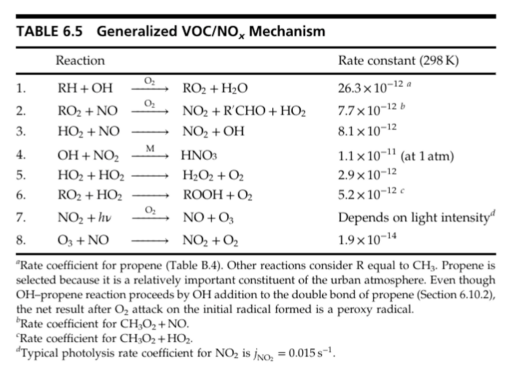

In [101]:
# Chemical Reaction Series
rxpath = os.path.expanduser("~/CES-2024/notebooks/reactionseries.png")
rx = plt.imread(rxpath)
plt.imshow(rx)
plt.axis('off')
plt.show()

# Rate Constants (at 298 K ~Room Temperature)
# cm3/(molecule/s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # unit: s-1
k8 = 1.9e-14

In [103]:
# Initial NOX/RH Concentration Ranges
# Units: Volume, ppb
nox_0 = 0
nox_max = 50
nox_range = np.linspace(nox_0, nox_max, 100)
rh_0 = 50
rh_max = 500
rh_range = np.linspace(rh_0, rh_max, 100)
nox, rh = np.meshgrid(nox_range, rh_range)

PHOx = 0.1 # ppt/s | Production rate of OH radicals; input of radical species that will start this reaction due to sunlight

In [104]:
# Ideal Gas Law: PV = nRT, or n/v = P/RT (in mols/volume in m3, molar density)
# If you have 80 ppb in [O3], you can find your concentration of [O3] in air like this:
# [O3] = 80 * 10e-9 * (P/RT)... additionall, can also include * (N/10e+6) for molecules/cm3
# Unit Conversions:
airden = (pres*avo)/(Rgas*temp*1e+6) # Air Density in molecules*cm-3
convert = 1e-9*airden
ppbfac = 1e9/airden

In [105]:
# Input initial NOx and RH values
# Output highest possible O3 values
# n[0] n[1] n[2] n[3] n[4] n[5] n[6]
# RH   NO   NO2  OH   RO2  HO2  O3
# n = NO + NO2 values
# r = RH values
# u[6] = Ozone values
def calculate_ozone(t, u):
    f = np.zeros(7)
    f[0] = -k1*u[0]*u[3]
    f[1] = -k2*u[4]*u[1] + k7*u[2] - k8*u[6]*u[1] - k3*u[5]*u[1]
    f[2] = k2*u[4]*u[1] + k3*u[5]*u[1] + k8*u[6]*u[1] - k7*u[2] - k4*u[3]*u[2]
    f[3] = -k1*u[0]*u[3] + k3*u[5]*u[1] - k4*u[3]*u[2] + CPHOx
    f[4] = k1*u[0]*u[3] - k2*u[4]*u[1] + k6*u[4]*u[5]
    f[5] = k2*u[4]*u[1] - k3*u[5]*u[1] - 2*k5*u[5]**2 - k6*u[4]*u[5]
    f[6] = k7*u[2] - k8*u[6]*u[1]
    return f

mO3 = np.zeros_like(nox)

In [121]:
# Timestep
Dt = 2 #seconds
t0 = 0
tmax = 24*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

In [122]:
for i in range(nox.shape[0]):
    for j in range(nox.shape[1]):
        initial_nox = nox[i, j]
        initial_rh = rh[i, j]
        cnox = initial_nox*convert
        crh = initial_rh*convert
        u0 = np.zeros(7)
        u0[0] = crh        # molecs/cm3 of RH hydrocarbon
        u0[1] = cnox*(2/3)
        u0[2] = cnox*(1/3)
        u0[3] = 0
        u0[4] = 0
        u0[5] = 0
        u0[6] = 0
        solution = solve_ivp(calculate_ozone, [t0, tmax], u0, method = 'LSODA', t_eval=t)
        mO3[i, j] = np.max(solution.y[6])*ppbfac

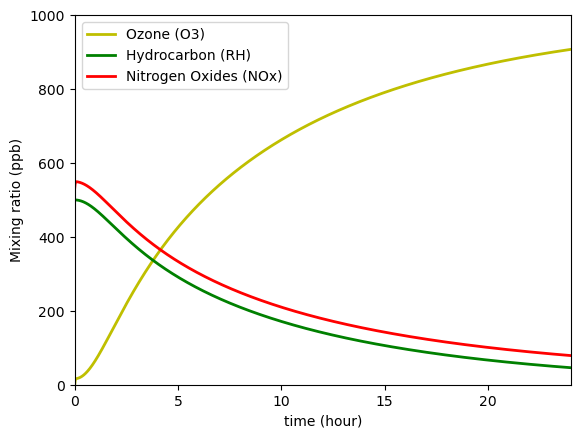

In [123]:
fig1 = plt.figure()
ax1 = plt.subplot(111)
plt.axis( [0, tmax/3600, 0, 1000] )
plt.plot( solution.t/3600, solution.y[6]*ppbfac, 'y-', lw=2, label='Ozone (O3)')
plt.plot( solution.t/3600, solution.y[0]*ppbfac, 'g-', lw=2, label='Hydrocarbon (RH)')
plt.plot( solution.t/3600, (solution.y[0] + solution.y[1])*ppbfac, 'r-', lw=2, label='Nitrogen Oxides (NOx)')
plt.xlabel('time (hour)')
plt.ylabel('Mixing ratio (ppb)')
plt.legend()

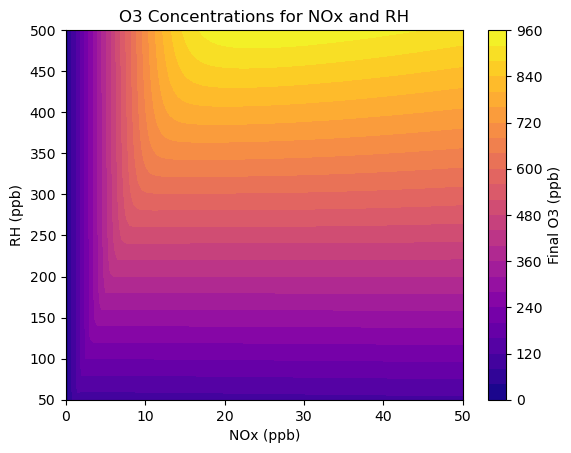

In [124]:
plt.contourf(nox, rh, mO3, levels = 30, cmap = "plasma")
plt.colorbar(label='Final O3 (ppb)')
plt.xlabel('NOx (ppb)')
plt.ylabel('RH (ppb)')
plt.title('O3 Concentrations for NOx and RH')
plt.show()

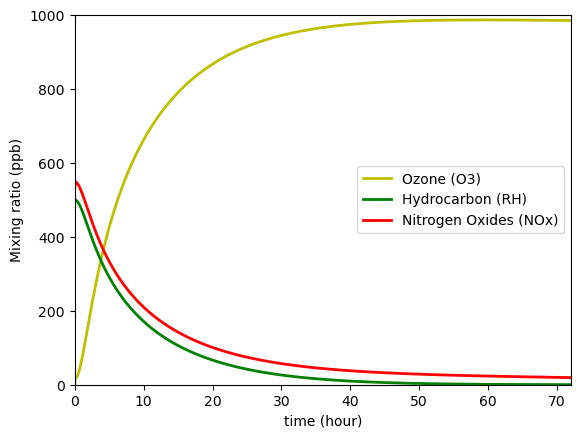

In [116]:
fig1 = plt.figure()
ax1 = plt.subplot(111)
plt.axis( [0, tmax/3600, 0, 1000] )
plt.plot( solution.t/3600, solution.y[6]*ppbfac, 'y-', lw=2, label='Ozone (O3)')
plt.plot( solution.t/3600, solution.y[0]*ppbfac, 'g-', lw=2, label='Hydrocarbon (RH)')
plt.plot( solution.t/3600, (solution.y[0] + solution.y[1])*ppbfac, 'r-', lw=2, label='Nitrogen Oxides (NOx)')
plt.xlabel('time (hour)')
plt.ylabel('Mixing ratio (ppb)')
plt.legend()